# Post Trade Analysis

Note: Please drag the SQLite file to the folder where you ran this notebook.

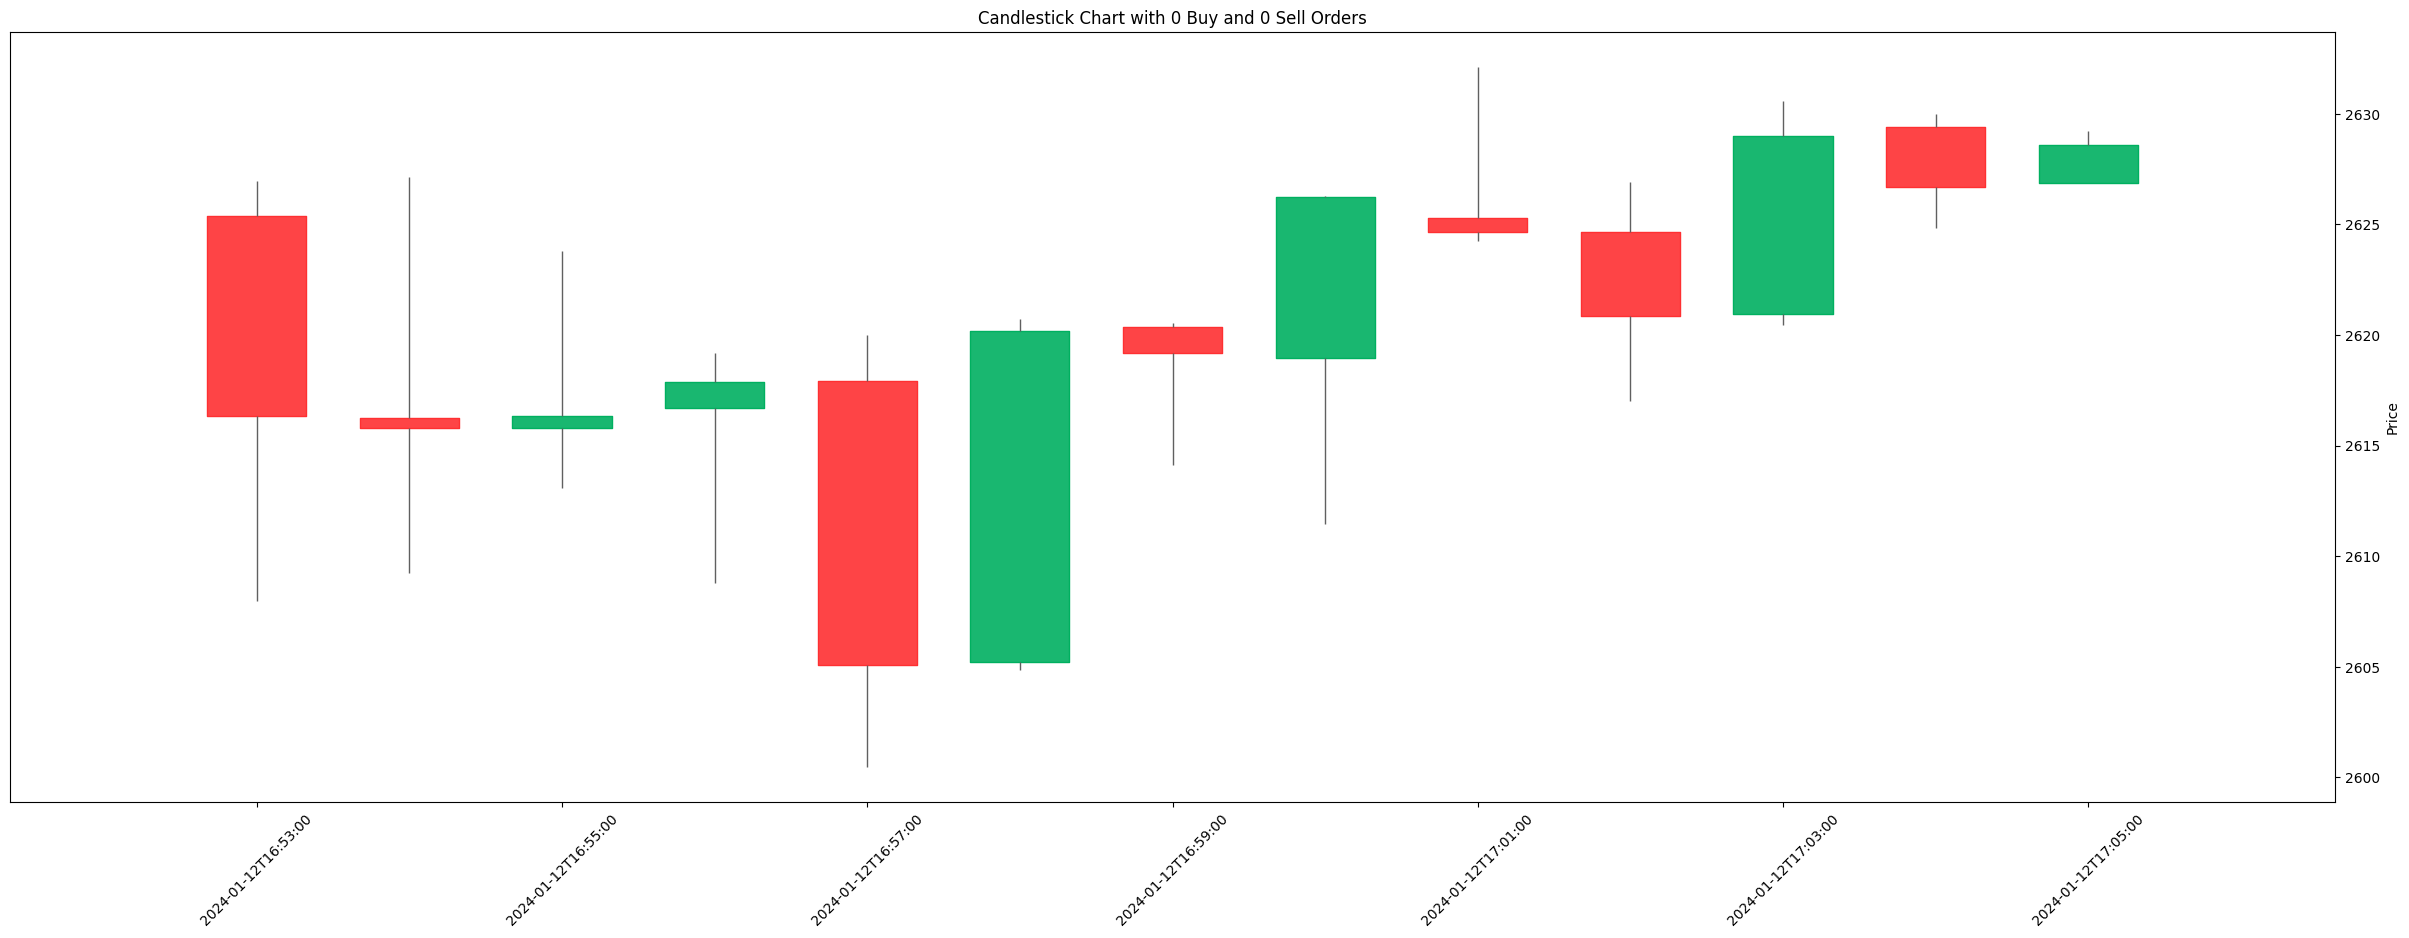

In [194]:
import numpy as np
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt
import sqlite3

def table_exists(conn: sqlite3.Connection, table_name: str)-> bool:        
    # SQL query to check if the table exists
    query = f"SELECT name FROM sqlite_master WHERE type='table' AND name='{table_name}';"
    
    # Execute the query
    query_result = pd.read_sql_query(query, conn)
    return len(query_result) > 0


def get_trades(conn: sqlite3.Connection, table_name: str, market_side: str) -> pd.DataFrame:
    if table_exists(conn, table_name):
        trades_df = pd.read_sql(f"select * from {table_name} where side='{market_side}'",
                         con=conn)
        trades_df["transaction_time"] = pd.to_datetime(trades_df["transaction_time"]).dt.round("1min")
        trades_df.set_index('transaction_time', inplace=True)
        
        return trades_df
    return pd.DataFrame()


def plot_trades(database_name: str):
    # Plotting candlestick chart with buy and sell orders
    fig, ax = plt.subplots(figsize=(30, 10))
    
    # Database connection
    conn = sqlite3.connect(database_name)

    # Read candlesticks from database
    df_candlesticks = pd.read_sql("select * from calculated_candlestick_feed", con=conn)
    df_candlesticks["start_time"] = pd.to_datetime(df_candlesticks["start_time"], format="%Y-%m-%d %H:%M:%S%z")
    df_candlesticks["end_time"] = pd.to_datetime(df_candlesticks["end_time"], format="%Y-%m-%d %H:%M:%S%z")
    df_candlesticks.set_index('start_time', inplace=True)

    # Additional plots to draw buy orders with green triangles and sell orders with red triangles
    add_plots = []

    # Read buy orders from database
    buy_orders_df = get_trades(conn, "order_fill", "buy")
    if len(buy_orders_df) > 0:
        buy_orders_df = buy_orders_df.reindex(df_candlesticks.index, axis='index', fill_value=np.NaN)
        add_plots.append(mpf.make_addplot(buy_orders_df['price'], type='scatter', markersize=100, marker='^', color='g', label='Buy Orders', ax=ax))

    # Read sell orders from database
    sell_orders_df = get_trades(conn, "order_fill", "sell")
    if len(sell_orders_df) > 0:
        sell_orders_df = sell_orders_df.reindex(df_candlesticks.index, axis='index', fill_value=np.NaN)
        add_plots.append(mpf.make_addplot(sell_orders_df['price'], type='scatter', markersize=100, marker='v', color='r', label='Sell Orders', ax=ax))
    
    # Plot candlestick chart
    mpf.plot(df_candlesticks, type='candle', ax=ax, style='yahoo', axtitle=f'Candlestick Chart with {len(buy_orders_df.dropna())} Buy and {len(sell_orders_df.dropna())} Sell Orders', ylabel='Price', datetime_format='%Y-%m-%dT%H:%M:%S', addplot=add_plots)

    # Display legend
    if len(add_plots) > 0:
        ax.legend()

    # Show the plot
    plt.show()
    
plot_trades('crypto.sqlite3')